
# Deep Learning: Assignment 6

    Implement various optimization algorithms given below on simple sigmoid neuron class (Gradient Descent, Mini-Batch GD,
    Momemtum-based GD, Nesterov Accelerated GD (NAG), Adaptive Gradients (AdaGrad), Root Mean Squared Propagation (RmsProp), Adam)
    Create a 2D contour plot and use animation to visulaze the convergence of all the various optimizers



In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm, animation, rc
import matplotlib.colors
from IPython.display import HTML

In [2]:
sns.set()


# Sigmoid Neuron Class

In [3]:
class SN:
    def __init__(self, w_init, b_init, algo):
        self.w = w_init
        self.b = b_init
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.algo = algo

    def sigmoid(self, x, w=None, b=None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        return 1. / (1. + np.exp(-(w*x + b)))

    def error(self, X, Y, w=None, b=None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        err = 0
        for x, y in zip(X, Y):
            err += 0.5 * (self.sigmoid(x, w, b) - y) ** 2
        return err

    def grad_w(self, x, y, w=None, b=None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * y_pred * (1 - y_pred) * x

    def grad_b(self, x, y, w=None, b=None):
        if w is None:
            w = self.w
        if b is None:
            b = self.b
        y_pred = self.sigmoid(x, w, b)
        return (y_pred - y) * y_pred * (1 - y_pred)

    def fit(self, X, Y, epochs=100, eta=0.01, gamma=0.9, mini_batch_size=100, eps=1e-8,  beta=0.9, beta1=0.9, beta2=0.9):
        self.w_h = []
        self.b_h = []
        self.e_h = []
        self.X = X
        self.Y = Y
        if self.algo == 'GD':
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                self.w -= eta * dw / X.shape[0]
                self.b -= eta * db / X.shape[0]
                self.append_log()
        elif self.algo == 'MiniBatch':
            for i in range(epochs):
                dw, db = 0, 0
                points_seen = 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                    points_seen += 1
                    if points_seen % mini_batch_size == 0:
                        self.w -= eta * dw / mini_batch_size
                        self.b -= eta * db / mini_batch_size
                        self.append_log()
                        dw, db = 0, 0
        elif self.algo == 'Momentum':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = gamma * v_w + eta * dw
                v_b = gamma * v_b + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                self.append_log()
        elif self.algo == 'NAG':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                v_w = gamma * v_w
                v_b = gamma * v_b
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
                    db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
                v_w = v_w + eta * dw
                v_b = v_b + eta * db
                self.w = self.w - v_w
                self.b = self.b - v_b
                self.append_log()
        elif self.algo == 'AdaGrad':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w += dw**2
                v_b += db**2
                self.w -= (eta / np.sqrt(v_w) + eps) * dw
                self.b -= (eta / np.sqrt(v_b) + eps) * db
                self.append_log()
        elif self.algo == 'RMSProp':
            v_w, v_b = 0, 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw += self.grad_w(x, y)
                    db += self.grad_b(x, y)
                v_w = beta * v_w + (1 - beta) * dw**2
                v_b = beta * v_b + (1 - beta) * db**2
                self.w -= (eta / np.sqrt(v_w) + eps) * dw
                self.b -= (eta / np.sqrt(v_b) + eps) * db
                self.append_log()
        elif self.algo == 'Adam':
            v_w, v_b = 0, 0
            m_w, m_b = 0, 0
            num_updates = 0
            for i in range(epochs):
                dw, db = 0, 0
                for x, y in zip(X, Y):
                    dw = self.grad_w(x, y)
                    db = self.grad_b(x, y)
                    num_updates += 1
                    m_w = beta1 * m_w + (1-beta1) * dw
                    m_b = beta1 * m_b + (1-beta1) * db
                    v_w = beta2 * v_w + (1-beta2) * dw**2
                    v_b = beta2 * v_b + (1-beta2) * db**2
                    m_w_c = m_w / (1 - np.power(beta1, num_updates))
                    m_b_c = m_b / (1 - np.power(beta1, num_updates))
                    v_w_c = v_w / (1 - np.power(beta2, num_updates))
                    v_b_c = v_b / (1 - np.power(beta2, num_updates))
                    self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_c
                    self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
                    self.append_log()

    def append_log(self):
        self.w_h.append(self.w)
        self.b_h.append(self.b)
        self.e_h.append(self.error(self.X, self.Y))


In [4]:
X = np.asarray([3.5, 0.35, 3.2, -2.0, 1.5, -0.5])
Y = np.asarray([0.5, 0.50, 0.5,  0.5, 0.1,  0.3])

algo = 'Adam'

w_init = -6
b_init = 4.0

w_min = -7
w_max = 5

b_min = -7
b_max = 5

epochs = 200
gamma = 0.9
eta = 0.5
eps = 1e-8

animation_frames = 20

plot_2d = True
plot_3d = False

<ipython-input-5-74156f3d40ec>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


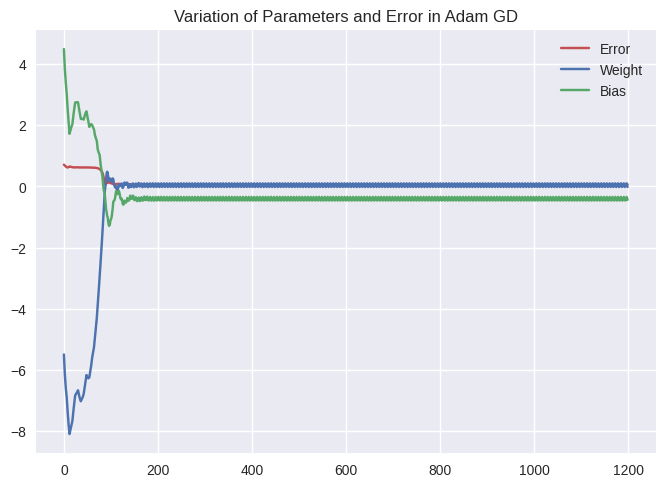

In [5]:
sn = SN(w_init, b_init, algo)
plt.style.use("seaborn")
sn.fit(X, Y, epochs=epochs, eta=eta, gamma=gamma)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
plt.legend(["Error","Weight","Bias"])
# w_diff = [t - s for t, s in zip(sn.w_h, sn.w_h[1:])]
# b_diff = [t - s for t, s in zip(sn.b_h, sn.b_h[1:])]
# plt.plot(w_diff, 'b--')
# plt.plot(b_diff, 'g--')
plt.title("Variation of Parameters and Error in Adam GD")
plt.show()

In [6]:
def plot_animate_3d(i):
    i = int(i*(epochs/animation_frames))
    line1.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    line1.set_3d_properties(sn.e_h[:i+1])
    line2.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    line2.set_3d_properties(np.zeros(i+1) - 1)
    title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
    return line1, line2, title

In [7]:
if plot_3d:
    W = np.linspace(w_min, w_max, 256)
    b = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, b)
    Z = sn.error(X, Y, WW, BB)

    fig = plt.figure(dpi=100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(WW, BB, Z, rstride=3, cstride=3, alpha=0.5, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    cset = ax.contourf(WW, BB, Z, 25, zdir='z', offset=-1, alpha=0.6, cmap=cm.coolwarm)
    ax.set_xlabel('w')
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel('b')
    ax.set_ylim(b_min - 1, b_max + 1)
    ax.set_zlabel('error')
    ax.set_zlim(-1, np.max(Z))
    ax.view_init (elev=25, azim=-75) # azim = -20
    ax.dist=12
    title = ax.set_title('Epoch 0')

In [8]:
if plot_3d:
    i = 0
    line1, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], sn.e_h[:i+1], color='black',marker='.')
    line2, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], np.zeros(i+1) - 1, color='red', marker='.')
    anim = animation.FuncAnimation(fig, func=plot_animate_3d, frames=animation_frames)
    rc('animation', html='jshtml')
    anim

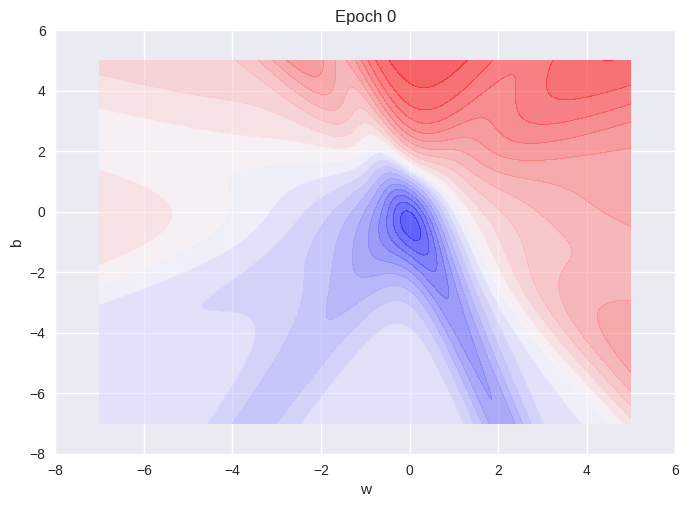

In [9]:
if plot_2d:
    W = np.linspace(w_min, w_max, 256)
    b = np.linspace(b_min, b_max, 256)
    WW, BB = np.meshgrid(W, b)
    Z = sn.error(X, Y, WW, BB)
    fig = plt.figure(dpi=100)
    ax = plt.subplot(111)
    ax.set_xlabel('w')
    ax.set_xlim(w_min - 1, w_max + 1)
    ax.set_ylabel('b')
    ax.set_ylim(b_min - 1, b_max + 1)
    title = ax.set_title('Epoch 0')
    cset = plt.contourf(WW, BB, Z, 25, alpha=0.6, cmap=cm.bwr)
    plt.show()

In [10]:
def plot_animate_2d(i):
    i = int(i*(epochs/animation_frames))
    line.set_data(sn.w_h[:i+1], sn.b_h[:i+1])
    title.set_text('Epoch: {: d}, Error: {:.4f}'.format(i, sn.e_h[i]))
    return line, title

In [11]:
if plot_2d:
    i = 0
    line, = ax.plot(sn.w_h[:i+1], sn.b_h[:i+1], color='black',marker='.')
    anim = animation.FuncAnimation(fig, func=plot_animate_2d, frames=animation_frames)
    rc('animation', html='jshtml')
    anim

In [14]:
if algo == 'GD':
  print('algo = {}, eta = {}'.format(algo, eta))
elif algo == 'Momentum' or algo == 'NAG':
  print('algo = {}, eta = {}, gamma = {}'.format(algo, eta, gamma))
elif algo == 'MiniBatch':
  print('algo = {}, eta = {}, batch size = {}'.format(algo, eta, mini_batch_size))
elif algo == 'AdaGrad' or algo == 'RMSProp':
  print('algo = {}, eta = {}, eps = {}'.format(algo, eta, eps))
anim




## Deep Learning: Assignment 6B

    Change the dataset for feedforward network
    Change the network accordingly.
    Apply the same optimizers given above for the simple FeedForward-Neural Network
    consisting and experiment using various optimizers to solve multi-class classification problem on dummy data.

**Import necessary libraries**

In [15]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

In [16]:
sns.set()


Generate Data

In [17]:
data, labels = make_blobs(n_samples = 1000, n_features = 2, centers = 4, random_state = 0)
print(data.shape, labels. shape)

(1000, 2) (1000,)


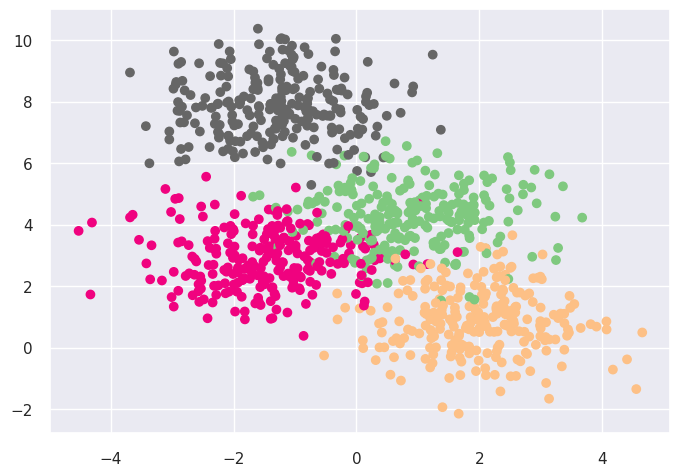

In [18]:
#plt.figure(figsize = (6, 4), dpi = 125)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'Accent')
#plt.plot()


# Multiclass Classification

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, Y_train.shape, X_val.shape)

(750, 2) (750,) (250, 2)


In [20]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()

Feedforward Network

In [21]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)

In [22]:
class network:
    def __init__(self, W1, W2):

        self.params = {}
        self.params["W1"] = W1.copy()
        self.params["W2"] = W2.copy()
        self.params["B1"] = np.zeros((1, 2))
        self.params["B2"] = np.zeros((1, 4))
        self.gradients = {}
        self.num_layers = 2
        self.update_params = {}
        self.prev_update_params = {}

        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0

    def sigmoid(self, X):
        return 1.0 / (1.0 + np.exp(-X))

    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)

    def forwardPass(self, X, params = None):
        if params is None: params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]            # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.sigmoid(self.A1)                                          # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]      # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2)                                          # (N, 4)
        return self.H2                                                           # (N, 4)

    def backpropagation(self, X, Y, params = None):
        if params is None: params = self.params

        m = X.shape[0]
        self.forwardPass(X, params)

        self.gradients["dA2"] = self.H2 - Y                                                     # (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                     # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)          # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], (self.H1 * (1 - self.H1)))   # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                           # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)          # (N, 2) -> (1, 2)

    def fit(self, X, Y, algo = 'GD', epochs = 1, eta = 1.0, display_loss = True,
            minibatch_size = 128, gamma = 0.9, eps = 1e-8, beta = 0.9, beta1 = 0.9,
            beta2 = 0.9):
        if display_loss:
            loss = {}

        m = X.shape[0]
        for e in tqdm(range(epochs), total = epochs, unit = "epoch"):
            if algo == 'GD':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / m))
                    self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / m))

            if algo == 'MiniBatch':
                for k in range(0, m, minibatch_size):
                    self.backpropagation(X[k:k + minibatch_size], Y[k:k + minibatch_size])
                    for i in range(1, self.num_layers + 1):
                        self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / minibatch_size))
                        self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / minibatch_size))

            if algo == 'Momentum':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+str(i)] -= self.update_params["v_b"+str(i)]

            if algo == "NAG":
                temp_params = {}
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.prev_update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)] = gamma * self.prev_update_params["v_b"+str(i)]

                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.backpropagation(X, Y, temp_params)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)] / m)
                    self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
                    self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)])
                self.prev_update_params = self.update_params

            if algo == "AdaGrad":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] += ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] += ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)

            if algo == "RMSProp":
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.update_params["v_w"+str(i)] = beta * (self.update_params["v_w"+str(i)]) + (1 - beta) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    self.update_params["v_b"+str(i)] = beta * (self.update_params["v_b"+str(i)]) + (1 - beta) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    self.params["W"+str(i)] -= (eta / (np.sqrt(self.update_params["v_w"+str(i)]) + eps)) * (self.gradients["dW"+str(i)] / m)
                    self.params["B"+str(i)] -= (eta / (np.sqrt(self.update_params["v_b"+str(i)]) + eps)) * (self.gradients["dB"+str(i)] / m)

            if algo == "Adam":
                self.backpropagation(X, Y)
                num_updates = 0
                for i in range(1, self.num_layers + 1):
                    num_updates += 1
                    self.update_params["m_w"+str(i)] = beta1 * (self.update_params["m_w"+str(i)]) + (1 - beta1) * (self.gradients["dW"+str(i)] / m)
                    self.update_params["v_w"+str(i)] = beta2 * (self.update_params["v_w"+str(i)]) + (1 - beta2) * ((self.gradients["dW"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_w"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_w"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["W"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

                    self.update_params["m_b"+str(i)] = beta1 * (self.update_params["m_b"+str(i)]) + (1 - beta1) * (self.gradients["dB"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = beta2 * (self.update_params["v_b"+str(i)]) + (1 - beta2) * ((self.gradients["dB"+str(i)] / m) ** 2)
                    m_w_c = self.update_params["m_b"+str(i)] / (1 - np.power(beta1, num_updates))
                    v_w_c = self.update_params["v_b"+str(i)] / (1 - np.power(beta2, num_updates))
                    self.params["B"+str(i)] -= (eta / (np.sqrt(v_w_c + eps))) * m_w_c

            if display_loss:
                Y_pred = self.predict(X)
                loss[e] = log_loss(Y, Y_pred)

        if display_loss:
            plt.plot(list(loss.values()), '-o', markersize = 3)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()

    def predict(self, X):
        Y_pred = self.forwardPass(X)
        return np.array(Y_pred).squeeze()

In [23]:
def accuracy_summary(display_graph = False):
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)

    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_val = np.argmax(Y_pred_val, 1)

    accuracy_train = accuracy_score(Y_train, Y_pred_train)
    accuracy_val = accuracy_score(Y_val, Y_pred_val)

    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))

    if display_graph:
        plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap='Set2', s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
        plt.show()

100%|██████████| 100/100 [00:00<00:00, 260.52epoch/s]


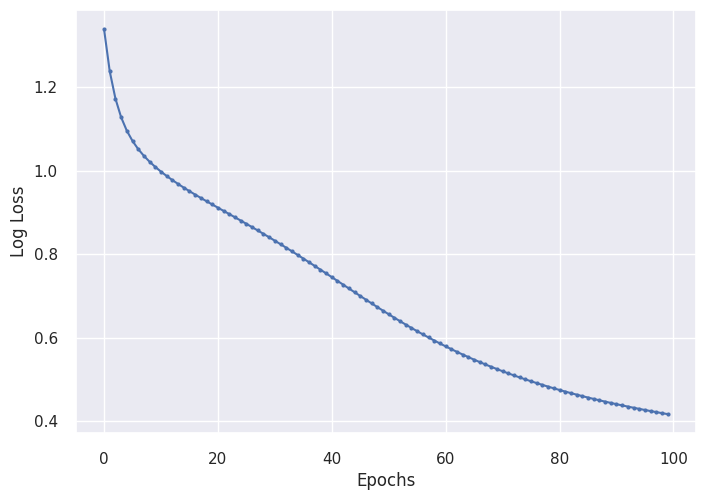

Training accuracy 0.892
Validation accuracy 0.904
CPU times: user 669 ms, sys: 70 ms, total: 739 ms
Wall time: 778 ms


In [24]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "GD", epochs = 100, eta = 1)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 348.56epoch/s]


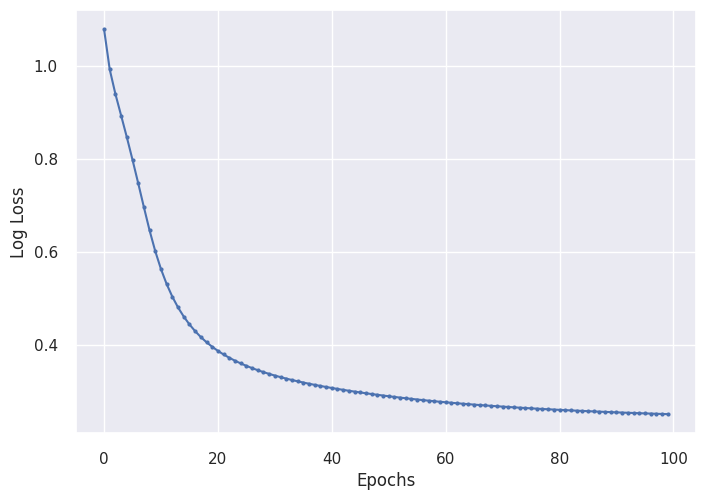

Training accuracy 0.9013
Validation accuracy 0.908
CPU times: user 605 ms, sys: 99.5 ms, total: 705 ms
Wall time: 609 ms


In [25]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 128)
accuracy_summary()

100%|██████████| 100/100 [00:01<00:00, 97.92epoch/s]


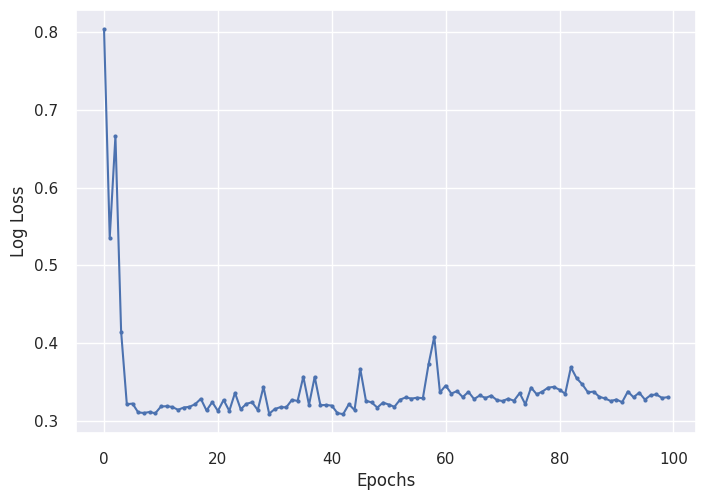

Training accuracy 0.8693
Validation accuracy 0.88
CPU times: user 1.3 s, sys: 107 ms, total: 1.41 s
Wall time: 1.3 s


In [26]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "MiniBatch", epochs = 100, eta = 1, minibatch_size = 8)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 453.70epoch/s]


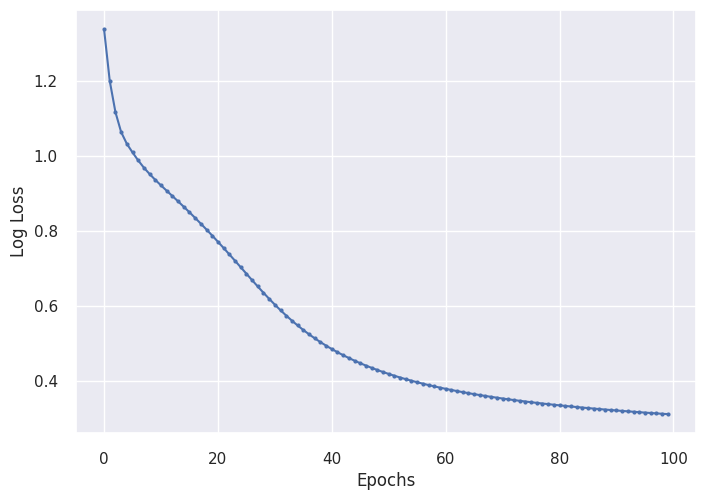

Training accuracy 0.892
Validation accuracy 0.9
CPU times: user 482 ms, sys: 106 ms, total: 588 ms
Wall time: 496 ms


In [27]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.5)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 435.77epoch/s]


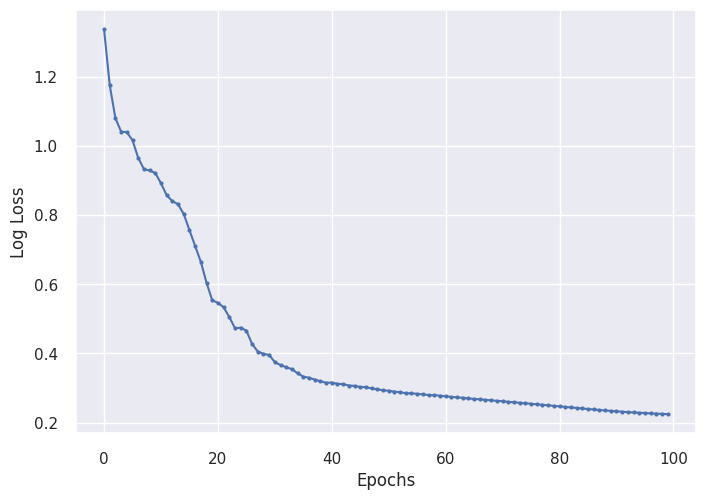

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 513 ms, sys: 96.6 ms, total: 610 ms
Wall time: 511 ms


In [28]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.9)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 456.06epoch/s]


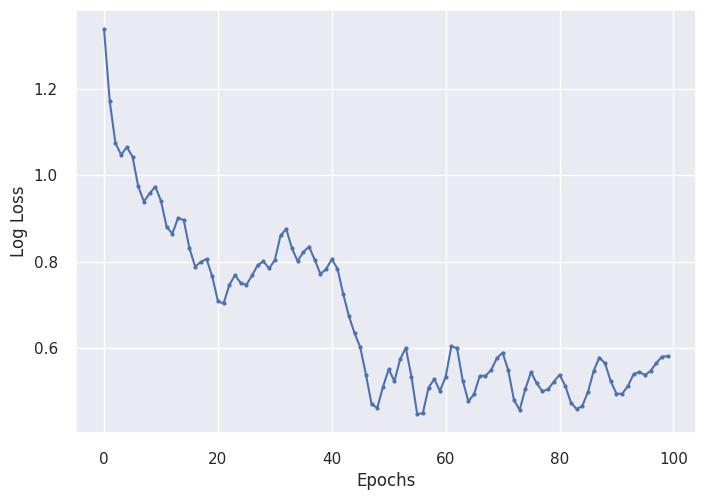

Training accuracy 0.864
Validation accuracy 0.836
CPU times: user 503 ms, sys: 111 ms, total: 614 ms
Wall time: 507 ms


In [29]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "Momentum", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()


100%|██████████| 100/100 [00:00<00:00, 435.71epoch/s]


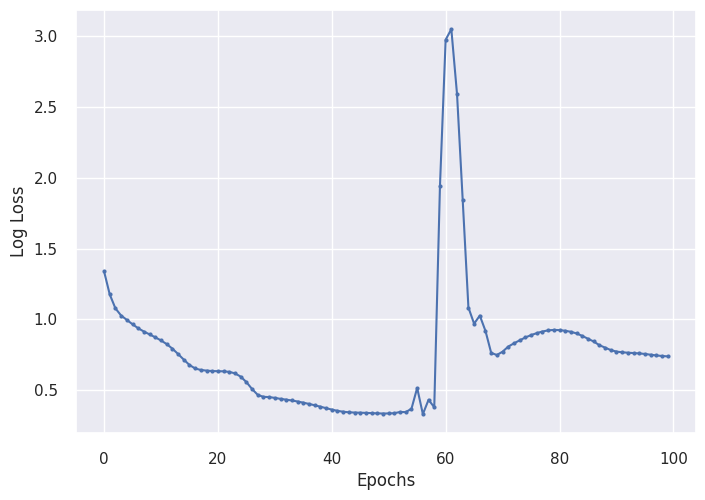

Training accuracy 0.672
Validation accuracy 0.696
CPU times: user 512 ms, sys: 98.2 ms, total: 611 ms
Wall time: 519 ms


In [30]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, algo = "NAG", epochs = 100, eta = 1, gamma = 0.99)
accuracy_summary()

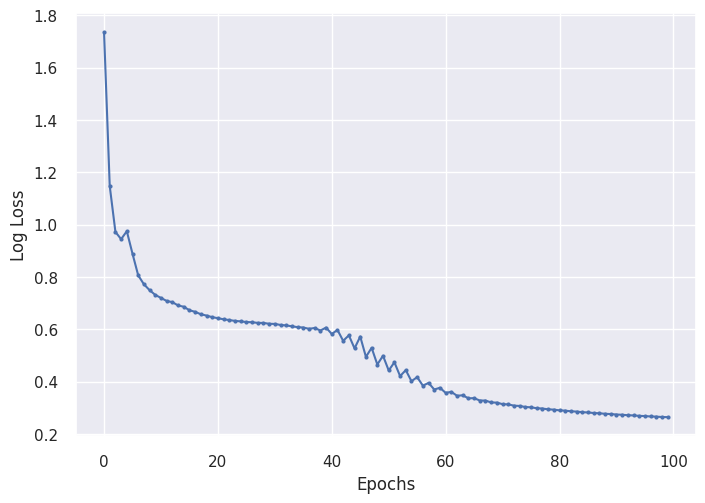

Training accuracy 0.8987
Validation accuracy 0.916
CPU times: user 528 ms, sys: 95.9 ms, total: 624 ms
Wall time: 526 ms


In [31]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 426.79epoch/s]


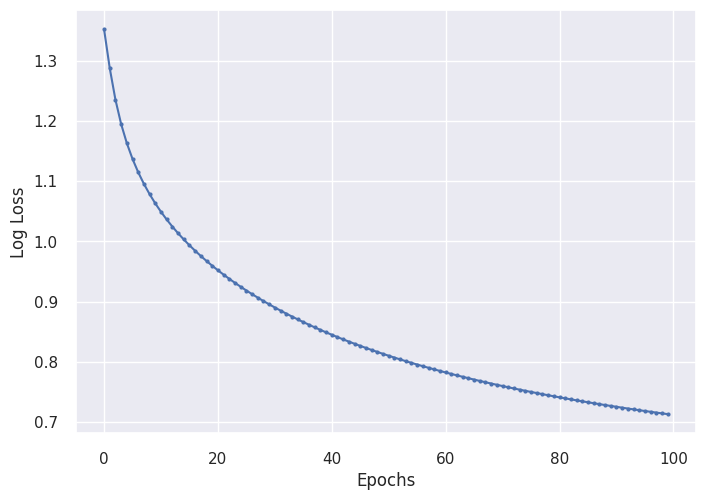

Training accuracy 0.704
Validation accuracy 0.732
CPU times: user 522 ms, sys: 108 ms, total: 630 ms
Wall time: 521 ms


In [33]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 293.01epoch/s]


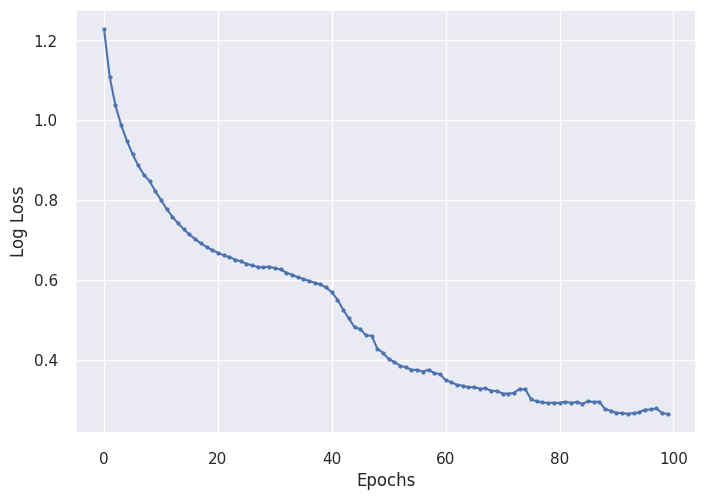

Training accuracy 0.9013
Validation accuracy 0.904
CPU times: user 677 ms, sys: 57.2 ms, total: 734 ms
Wall time: 729 ms


In [34]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 438.79epoch/s]


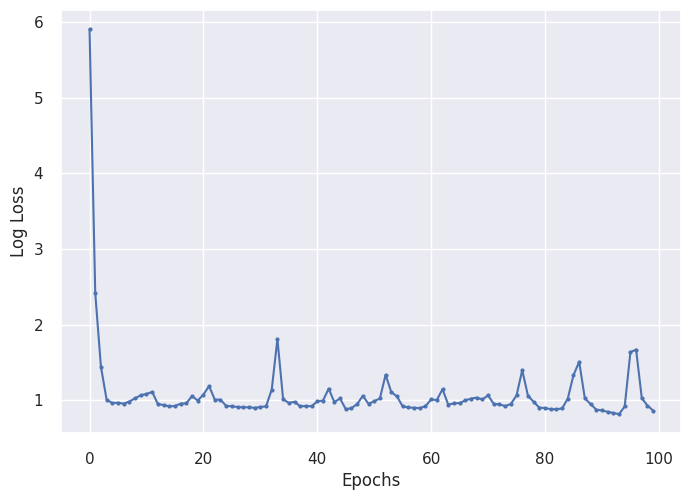

Training accuracy 0.5027
Validation accuracy 0.496
CPU times: user 626 ms, sys: 113 ms, total: 739 ms
Wall time: 621 ms


In [35]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 100/100 [00:00<00:00, 439.44epoch/s]


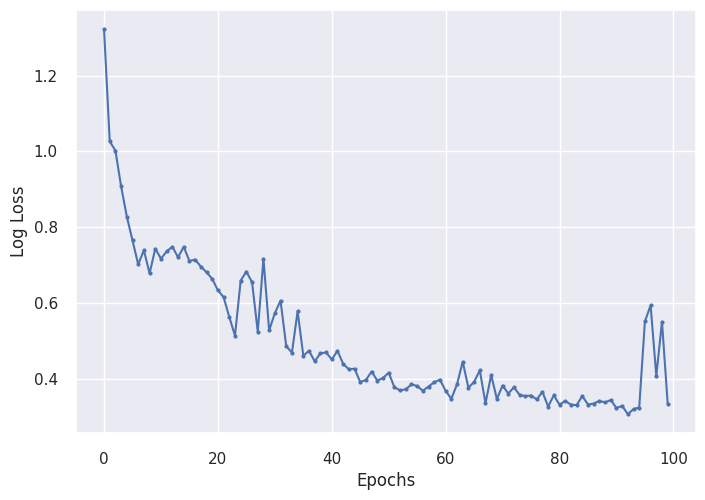

Training accuracy 0.884
Validation accuracy 0.876
CPU times: user 514 ms, sys: 100 ms, total: 614 ms
Wall time: 505 ms


In [36]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()


100%|██████████| 100/100 [00:00<00:00, 408.05epoch/s]


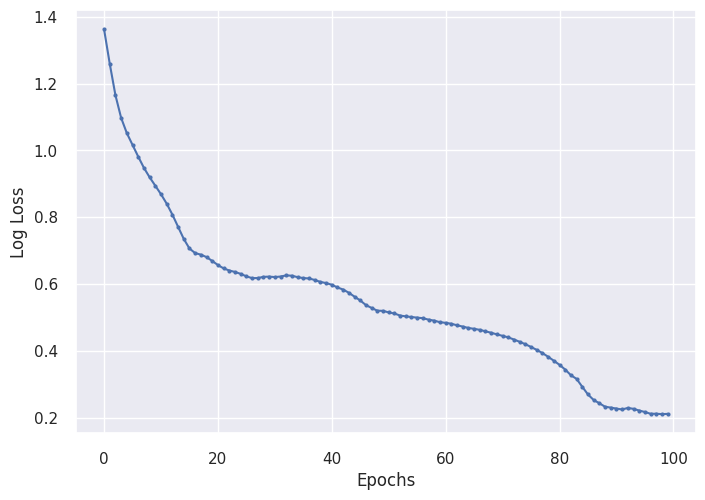

Training accuracy 0.916
Validation accuracy 0.924


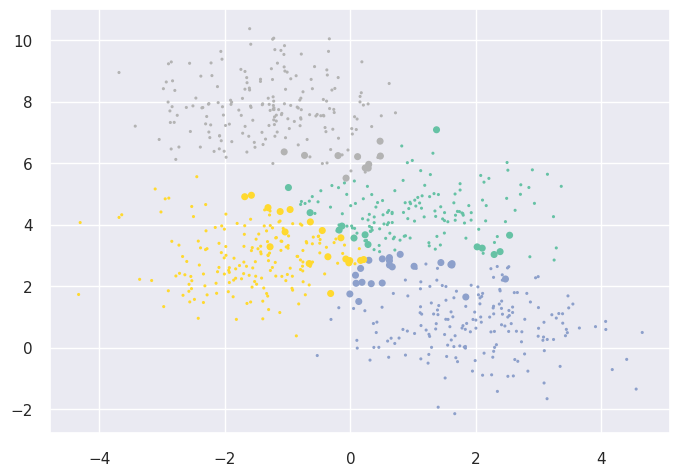

CPU times: user 809 ms, sys: 211 ms, total: 1.02 s
Wall time: 798 ms


In [37]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary(display_graph = True)

Good Configuration for Each Algorithm

100%|██████████| 10000/10000 [00:28<00:00, 347.08epoch/s]


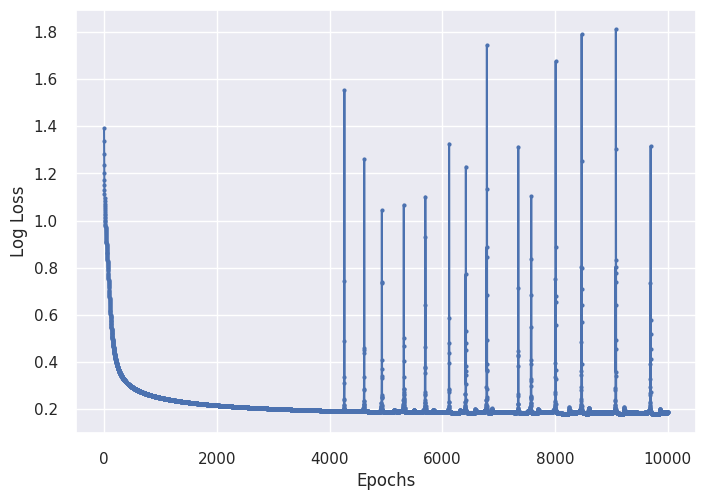

Training accuracy 0.9213
Validation accuracy 0.928
CPU times: user 25.9 s, sys: 187 ms, total: 26 s
Wall time: 29.1 s


In [38]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
accuracy_summary()

100%|██████████| 1000/1000 [00:02<00:00, 458.28epoch/s]


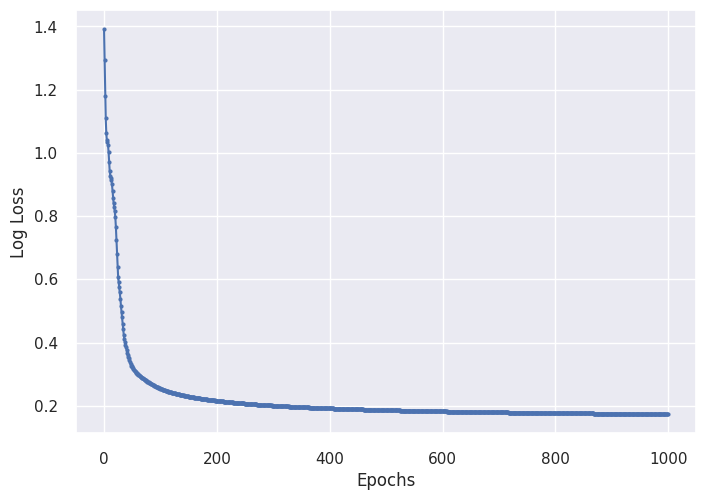

Training accuracy 0.928
Validation accuracy 0.94
CPU times: user 2.43 s, sys: 126 ms, total: 2.55 s
Wall time: 2.47 s


In [39]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 1000/1000 [00:03<00:00, 320.62epoch/s]


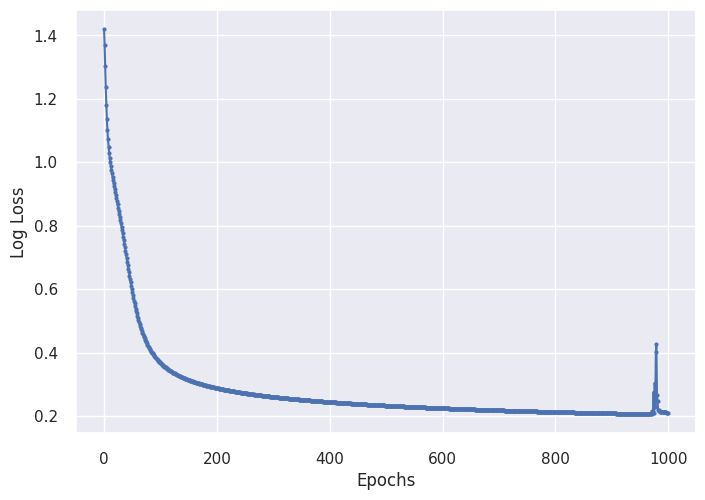

Training accuracy 0.9173
Validation accuracy 0.94
CPU times: user 3 s, sys: 42.5 ms, total: 3.05 s
Wall time: 4.07 s


In [40]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 500/500 [00:01<00:00, 437.65epoch/s]


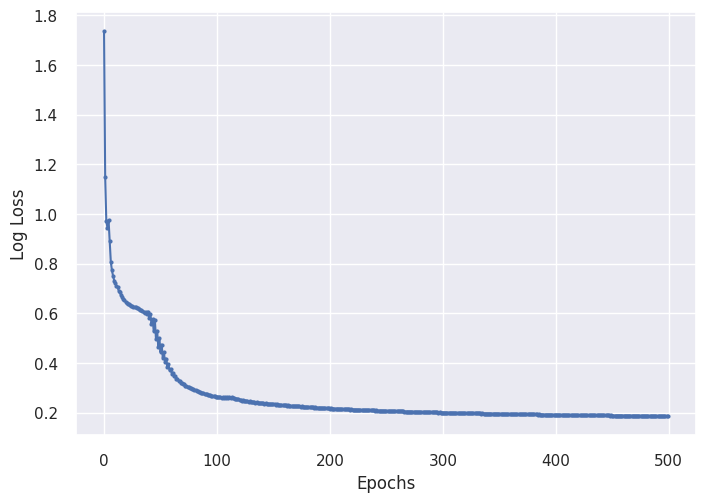

Training accuracy 0.9227
Validation accuracy 0.94
CPU times: user 1.44 s, sys: 97.1 ms, total: 1.54 s
Wall time: 1.45 s


In [41]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
accuracy_summary()

100%|██████████| 2000/2000 [00:06<00:00, 298.00epoch/s]


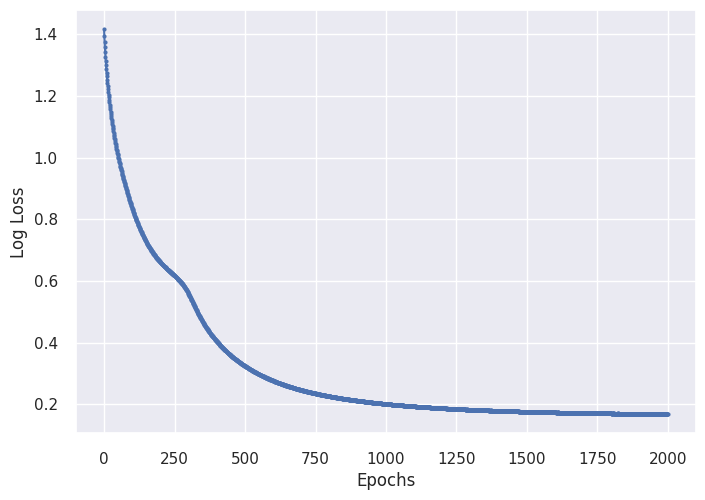

Training accuracy 0.928
Validation accuracy 0.944
CPU times: user 6.08 s, sys: 141 ms, total: 6.22 s
Wall time: 7.04 s


In [42]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
accuracy_summary()

100%|██████████| 200/200 [00:00<00:00, 429.32epoch/s]


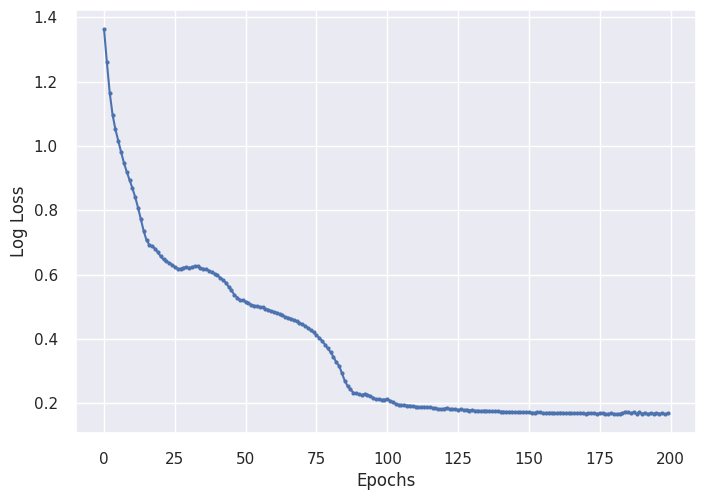

Training accuracy 0.9293
Validation accuracy 0.94
CPU times: user 776 ms, sys: 93.1 ms, total: 870 ms
Wall time: 779 ms


In [43]:
%%time
model = network(W1, W2)
model.fit(X_train, Y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
accuracy_summary()